### Download libraries

In [ ]:
import requests

import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
import time
import random
from collections import Counter

from pymorphy3 import MorphAnalyzer
import nltk
import spacy

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import cross_val_score, train_test_split
from operator import itemgetter
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

### Set VK API methods and access_token

In [ ]:
url = "https://api.vk.com/method/groups.getMembers"
url2 = "https://api.vk.com/method/groups.get"

access_token = "YOUR_TOKEN"
p = {"access_token":access_token, "v":"5.199"}

### Extract members from the group
I choose a group dedicated to the work of Hayao Miyazaki, as I want to find out what his fans are interested in. Let's extract 1000 members.

In [ ]:
def get_members(ID, how_many_members):
    members_list = []
    p["group_id"] = ID
    p["count"] = 100

    for offset in tqdm(range(0, how_many_members, 100)):
        p["offset"] = offset
        inf = requests.get(url, params = p).json()
        time.sleep(0.24)
        for member in inf["response"]["items"]:
            members_list.append(member)

    return members_list

In [ ]:
members_list = get_members("miyazaki_club", 1000)
len(members_list)

  0%|          | 0/10 [00:00<?, ?it/s]

1000

### Extract groups of each member

In [ ]:
def get_users_groups(members, how_many_groups):

    p = {"access_token":access_token, "fields":"description", "extended":1, "count":how_many_groups}
    id_of_group = []
    name_of_group = []
    description_of_group = []
    versions = ["5.199", "5.195", "5.194", "5.154", "5.141", "5.139"]

    for user_groups in tqdm(members):
        p["user_id"] = user_groups
        p["v"] = random.choice(versions)
        inf = requests.get(url3, params = p).json()
        time.sleep(0.12)

        if "response" in inf:
            for num_group in range(0, inf["response"]["count"], 1):
                try:
                    id_of_group.append(inf["response"]["items"][num_group]["id"])
                except:
                    id_of_group.append("-")
                try:
                    name_of_group.append(inf["response"]["items"][num_group]["name"])
                except:
                    name_of_group.append("-")
                try:
                    description_of_group.append(inf["response"]["items"][num_group]["description"])
                except:
                    description_of_group.append("-")


    df_of_groups = pd.DataFrame(list(zip(id_of_group, name_of_group, description_of_group)),
                                       columns = ["ID", "Name of Group", "Description of Group"])

    df_of_groups = df_of_groups.loc[df_of_groups["ID"] != "-"].reset_index(drop = True)

    return df_of_groups

In [ ]:
df_of_groups = get_users_groups(members_list, 50)
df_of_groups

  0%|          | 0/1000 [00:00<?, ?it/s]

,ID,Name of Group,Description of Group
0,68471405,ДТП и ЧП | Санкт-Петербург | Питер Онлайн | СПб,Если вы стали очевидцем происшествия или хотит...
1,65960786,Лепрозорий,Лечебно-профилактическое учреждение для людей ...
2,55442956,Leprosorium,
3,72199240,dextromethorphan 3,Наша небольшая уютная компания согреет тебя да...
4,60114472,Albertina,
...,...,...,...
29654,3510887,*Хаяо Миядзаки*,Почитатели творчества Хаяо Миадзаки.\nХодячий ...
29655,18941273,Проекты Андрея Парабеллума,Андрей Парабеллум\n\n🏆 Рекордсмен Книги Рекорд...
29656,22898541,#Инфографика в примерах,"Эта страница блога ""Инфографика в примерах"", с..."
29657,24094338,Лайфхакер,"Мы рассказываем обо всём, что улучшает жизнь, ..."


### Text Preprocessing

In [ ]:
group_description = df_of_groups["Description of Group"]
morph = MorphAnalyzer()
pos_list = ["NOUN", "ADJF", "COMP", "ADJS", "VERB", "INFN", "PRTF", "PRTS", "ADVB"] # list with parts of speech

def preprocess_text(group_description, exclude_stop_words=True):
    tokenized_text = []
    lemmatized_text = []

    for x in group_description:
        tokenized_text.append(nltk.word_tokenize(x))

    if exclude_stop_words:
        stop_words_spacy = list(spacy.load('ru_core_news_sm').Defaults.stop_words)
        stop_words_nltk = nltk.corpus.stopwords.words('russian')
        russian_stop_words = set(stop_words_spacy + stop_words_nltk)
        for text in tqdm(tokenized_text):
            text_tokens = []
            for token in text:
                token_morph = morph.parse(token)[0] # [0] - most likely description of the word
                if token_morph.tag.POS in pos_list and token_morph.normal_form not in russian_stop_words and token not in russian_stop_words:
                    text_tokens.append(token_morph.normal_form)
            lemmatized_text.append(text_tokens)

    else:

        for text in tqdm(tokenized_text):
            text_tokens = []
            for token in text:
                token_morph = morph.parse(token)[0]
                if token_morph.tag.POS in pos_list:
                    text_tokens.append(token_morph.normal_form)
            lemmatized_text.append(text_tokens)

    return lemmatized_text


def bag_of_words(text):
    all_tokens = []

    for lemm_list in tqdm(text):
        for word in lemm_list:
            all_tokens.append(word)

    return pd.DataFrame(dict(Counter(all_tokens)).items(), columns=["Token", "Frequency"])\
                        .sort_values(by="Frequency", ascending=False).reset_index(drop=True)


def joined_bag(text):
    text_for_vektors = []

    for t in tqdm(text):
        joined_lemmas = []
        if len(t) > 1:
            joined_lemmas.append(" ".join(t))
        text_for_vektors.append(" ".join(joined_lemmas))

    return text_for_vektors

In [ ]:
lemmatized_text = preprocess_text(group_description)
bag = bag_of_words(lemmatized_text)
j_bag = joined_bag(lemmatized_text)

  0%|          | 0/29659 [00:00<?, ?it/s]

  0%|          | 0/29659 [00:00<?, ?it/s]

  0%|          | 0/29659 [00:00<?, ?it/s]

In [ ]:
bag.head(30)

,Token,Frequency
0,группа,7429
1,сообщество,6496
2,новость,5043
3,год,4680
4,человек,4566
5,мир,4304
6,жизнь,3427
7,интересный,3410
8,хороший,3197
9,новый,3184


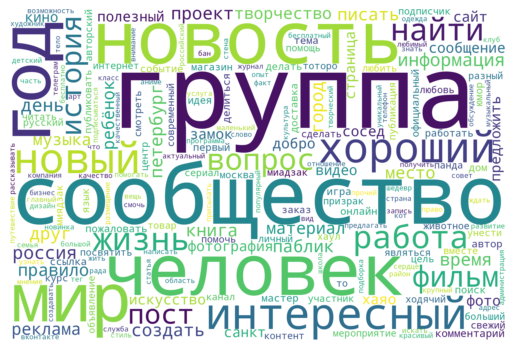

In [ ]:
# Visualize tokens
word_cloud = WordCloud(collocations = False, background_color = 'white',
                       width = 2160, height = 1440).generate(str(j_bag))

plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Clustering with LDA

In [ ]:
# Clustering tokens
tfidf = TfidfVectorizer(max_features = 1500)
x = tfidf.fit_transform(j_bag).toarray()
cluster_num = 15
lda = LatentDirichletAllocation(n_components = cluster_num,
                                learning_method = "batch",
                                max_iter = 150,
                                random_state = 0)

document_topics = lda.fit_transform(x)

sorting = np.argsort(lda.components_, axis = 1)[:, ::-1]
feature_names = np.array(list(dict(sorted(tfidf.vocabulary_.items(), key = itemgetter(1))).keys()))
clusters_tokens = []
for num in tqdm(range(0, cluster_num)):
    tokens_list = list(feature_names[list(sorting[num])])
    clusters_tokens.append(tokens_list)

df_clust = pd.DataFrame(clusters_tokens).T
#pd.DataFrame(document_topics)

  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
df_clust.head(40)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,язык,юмор,идея,петербург,книга,хаяо,официальный,новость,рубрика,группа,искусство,год,новость,подписаться,фильм
1,английский,рецепт,реклама,магазин,литература,замок,канал,предложить,хороший,правило,современный,человек,интересный,путешествие,кино
2,бизнес,сарказм,украшение,санкт,психология,сосед,сообщество,сообщество,паблик,сообщество,добро,группа,жизнь,пост,сериал
3,вконтакте,заходить,мастер,заказ,мысль,миядзак,страница,присылать,интересный,пост,пожаловать,жизнь,мир,паблик,хороший
4,сообщество,настроение,одежда,работа,концерт,панда,телеграм,фото,сообщество,реклама,художник,ребёнок,история,читать,журнал
5,первый,жизнь,интерьер,доставка,сообщество,унести,игра,интересный,любитель,объявление,мир,музыка,наука,лента,новость
6,познавательный,подписываться,дизайн,россия,чтение,ходячий,вопрос,вдохновение,город,комментарий,арт,проект,факт,татуировка,новинка
7,учить,суета,мир,товар,издательство,призрак,группа,группа,добрый,бан,музыка,мир,событие,фильм,главный
8,место,хороший,вкусный,москва,книжный,тоторо,новость,работа,иллюстрация,новость,живопись,школа,человек,сообщество,свежий
9,душа,япония,красота,телефон,афиша,хаул,сотрудничество,идея,полезный,публикация,история,время,звезда,контент,новый


Looks like there are 4 clusters that signal the interests of Miyazaki's audience. Cluster "4" dedicated to literature and love for books; cluster "10" focuses on the passion for art and creativity; cluster "12" is about the world, history and science; seems like cluster "14" is about cinema.

###Сalculating presence of each cluster

In [ ]:
# Classification on clusters
clusters_imp = [4, 10, 12, 14] # Important clusters

cluster_solution = []
for mark_list in tqdm(document_topics):
    cluster_solution.append(mark_list[clusters_imp])

y = []
for marks_lists in tqdm(cluster_solution):
    m = list(marks_lists)
    y.append(m.index(max(m)))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

classifier = LogisticRegression(max_iter=300) # may require more detailed configuration

classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
cross_validation = cross_val_score(classifier, x, y, cv=5)

print("Train data:", round(classifier.score(x_train, y_train), 3))
print("Test data:", round(classifier.score(x_test, y_test), 3))
print("\n", classification_report(y_test, y_pred))
print("Cross validation:", cross_validation, "≈", round(cross_validation.mean(), 3))

scores = classifier.predict_proba(tfidf.fit_transform(j_bag).toarray())
df_list = []
index = 0
for t in x:
    df_list.append(list(np.append(t, scores[index])))
    index += 1

  0%|          | 0/29659 [00:00<?, ?it/s]

  0%|          | 0/29659 [00:00<?, ?it/s]

Train data: 0.863
Test data: 0.815

               precision    recall  f1-score   support

           0       0.79      0.89      0.84      1989
           1       0.83      0.77      0.80      1401
           2       0.82      0.83      0.82      1566
           3       0.86      0.71      0.78       976

    accuracy                           0.81      5932
   macro avg       0.82      0.80      0.81      5932
weighted avg       0.82      0.81      0.81      5932

Cross validation: [0.81793661 0.82130816 0.82181389 0.82855698 0.82532457] ≈ 0.823


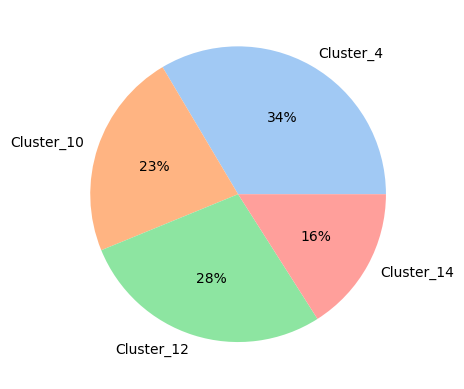

In [ ]:
clusters_probs = pd.DataFrame(df_list).iloc[:, -len(clusters_imp):]\
                                      .set_axis(["Cluster_" + str(i) for i in clusters_imp], axis=1)

clusters_presence = clusters_probs.sum()

colors = sns.color_palette('pastel')
plt.pie(clusters_presence, labels = clusters_presence.index,
        colors = colors, autopct='%.0f%%')
plt.show()

Now we have probable distribution of the interests of Hayao Miyazaki's fans. It seems that they spend a lot of time reading and they generally care about art and the world around them.